# Modularized with utils.dm
This notebook now uses shared helpers from `utils/dm.py` to load data, preprocess, visualize, and persist artifacts consistently across tasks.

# Section 2: Data Mining
## Task 1: Data Preprocessing and Exploration (15 Marks)
This notebook fulfills the Task 1 requirements: load (or generate) the dataset, preprocess (missing values, scaling, encoding), explore (summary stats, pairplot, correlation heatmap, outlier inspection via boxplots), and implement a reusable 80/20 train/test split function.
You may choose between: (A) the classic Iris dataset (default) or (B) synthetic Iris‑like data. Toggle via the parameter below.

In [1]:
# 1. Imports & Configuration
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import json, textwrap, random

# Plot style
sns.set_theme(style='whitegrid', context='notebook')
ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)

# Parameter: choose dataset option ('iris' or 'synthetic')
DATA_OPTION = 'iris'  # change to 'synthetic' to generate data
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(f'Data option: {DATA_OPTION}')

Data option: iris


In [2]:
# Imports & setup via utils.dm
import sys
from pathlib import Path

# Ensure project root is on sys.path so 'utils' is importable when running from this folder
ROOT = Path.cwd()
for parent in [ROOT] + list(ROOT.parents):
    if (parent / 'utils' / 'dm.py').exists():
        sys.path.insert(0, str(parent))
        break

from utils import dm
import numpy as np, random
np.random.seed(42); random.seed(42)
ARTIFACT_DIR = Path('artifacts'); ARTIFACT_DIR.mkdir(exist_ok=True)
DATA_OPTION = 'iris'  # or 'synthetic'
print(f'Data option: {DATA_OPTION}')

Data option: iris


In [3]:
# 2. Load or Generate Dataset (via utils.dm)
df = dm.load_or_generate(DATA_OPTION)
print('Data shape:', df.shape)
display(df.head())

Data shape: (150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# 3. Missing Value Checks & Handling (illustrative)
missing_counts = df.isna().sum()
print('Missing value counts per column:', missing_counts.to_dict())
if missing_counts.any():
    before = len(df)
    df = df.dropna()
    print(f'Dropped {before - len(df)} rows containing missing values.')
else:
    print('No missing values detected.')

Missing value counts per column: {'sepal length (cm)': 0, 'sepal width (cm)': 0, 'petal length (cm)': 0, 'petal width (cm)': 0, 'class': 0}
No missing values detected.


In [5]:
# 4. Feature / Target Separation (via utils.dm)
X, y, feature_cols = dm.split_features(df)
print('Features shape:', X.shape, '| Target shape:', y.shape)
print('Class distribution:', y.value_counts().to_dict())

Features shape: (150, 4) | Target shape: (150,)
Class distribution: {np.str_('setosa'): 50, np.str_('versicolor'): 50, np.str_('virginica'): 50}


In [6]:
# 5. Normalization and Optional One-Hot Encoding (via utils.dm)
X_scaled = dm.scale_features(X)
print('Scaled feature range summary (min, max) per column:')
for col in feature_cols:
    print(col, (round(X_scaled[col].min(),3), round(X_scaled[col].max(),3)))

y_ohe_df, encoded_classes = dm.one_hot_encode(y)
display(y_ohe_df.head())
print('One-hot shape:', y_ohe_df.shape)

Scaled feature range summary (min, max) per column:
sepal length (cm) (np.float64(0.0), np.float64(1.0))
sepal width (cm) (np.float64(0.0), np.float64(1.0))
petal length (cm) (np.float64(0.0), np.float64(1.0))
petal width (cm) (np.float64(0.0), np.float64(1.0))


,class_setosa,class_versicolor,class_virginica
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


One-hot shape: (150, 3)


In [7]:
# 6. Summary Statistics (via utils.dm)
summary = dm.save_summary_stats(X, Path('artifacts') / 'summary_stats.csv')
display(summary)
print('Saved summary statistics to artifacts/summary_stats.csv')

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


Saved summary statistics to artifacts/summary_stats.csv


Saved pairplot to artifacts/pairplot_scaled.png


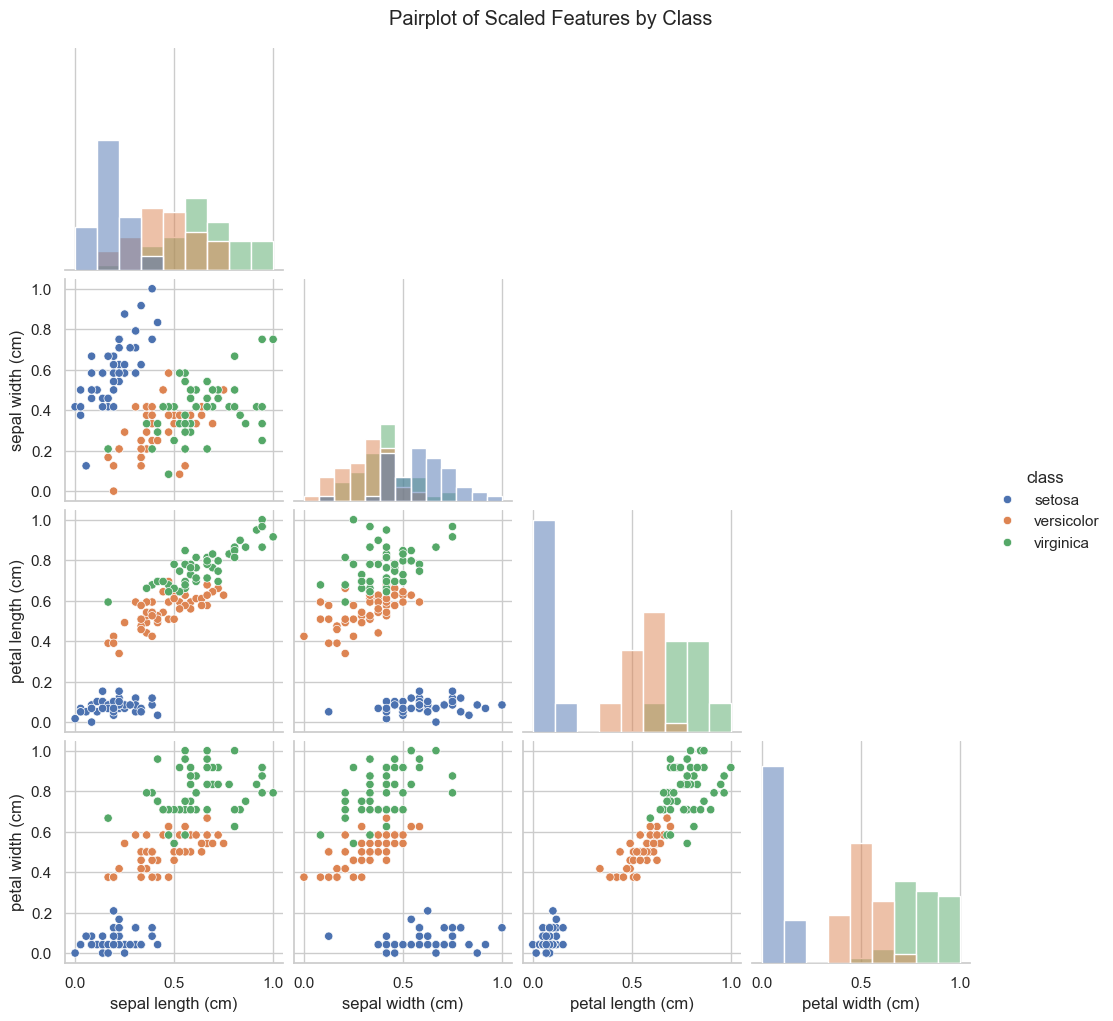

In [8]:
# 7. Pairplot Visualization (via utils.dm)
dm.plot_pairplot(pd.concat([X_scaled, y], axis=1), hue='class', save_path=Path('artifacts') / 'pairplot_scaled.png')
print('Saved pairplot to artifacts/pairplot_scaled.png')

Saved heatmap to artifacts/correlation_heatmap.png


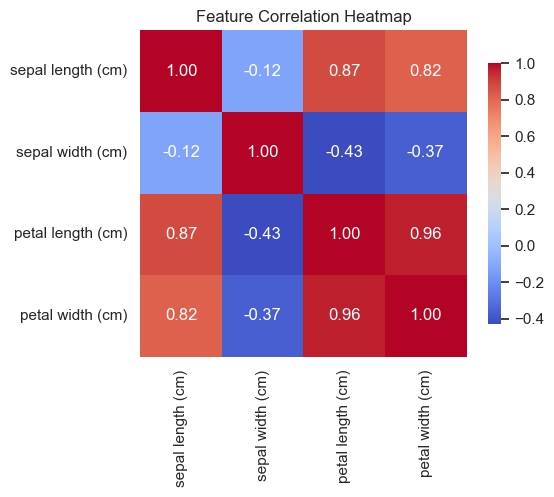

In [9]:
# 8. Correlation Heatmap (via utils.dm)
dm.plot_correlation_heatmap(X, save_path=Path('artifacts') / 'correlation_heatmap.png')
print('Saved heatmap to artifacts/correlation_heatmap.png')

Saved boxplots to artifacts/boxplots_scaled.png
Outlier counts per feature: {'sepal length (cm)': 0, 'sepal width (cm)': 4, 'petal length (cm)': 0, 'petal width (cm)': 0}


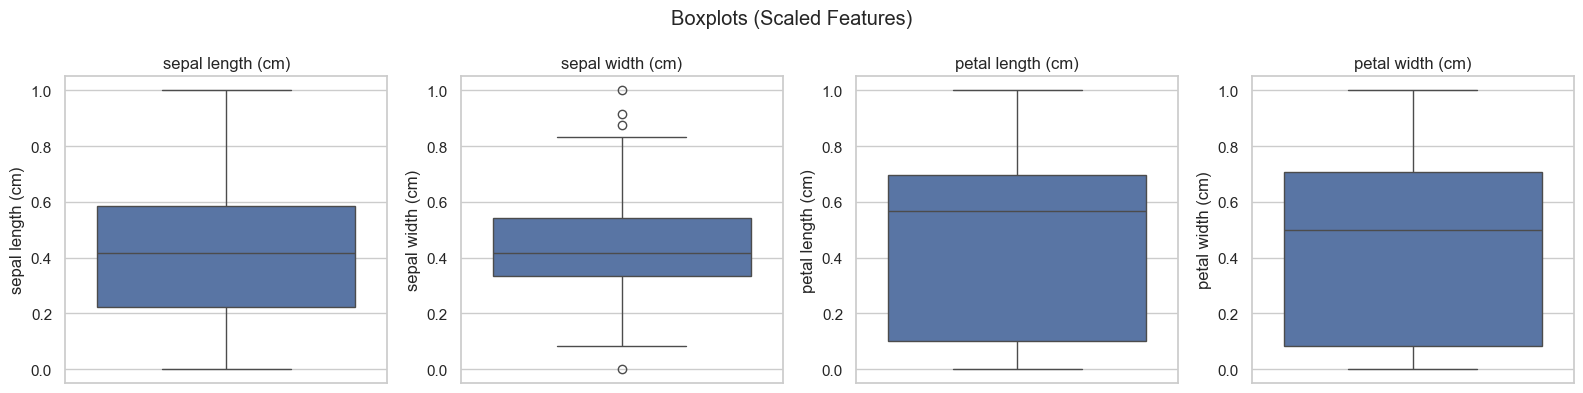

In [10]:
# 9. Outlier Identification via Boxplots (via utils.dm)
outlier_summary = dm.plot_boxplots_and_outliers(X_scaled, save_path=Path('artifacts') / 'boxplots_scaled.png')
print('Saved boxplots to artifacts/boxplots_scaled.png')
print('Outlier counts per feature:', outlier_summary)

In [11]:
# 10. Train/Test Split (80/20) Function (via utils.dm)
X_train, X_test, y_train, y_test = dm.train_test_split_custom(X_scaled, y, test_size=0.2, shuffle=True, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape, '|', y_train.shape, y_test.shape)
print('Train class distribution:', y_train.value_counts().to_dict())
print('Test class distribution:', y_test.value_counts().to_dict())

Train/Test shapes: (120, 4) (30, 4) | (120,) (30,)
Train class distribution: {np.str_('versicolor'): 44, np.str_('virginica'): 39, np.str_('setosa'): 37}
Test class distribution: {np.str_('setosa'): 13, np.str_('virginica'): 11, np.str_('versicolor'): 6}


In [12]:
# 11. Lightweight Validation & Metadata Export
metadata = {
    'data_option': DATA_OPTION,
    'n_rows': int(len(df)),
    'feature_columns': feature_cols,
    'class_labels': sorted(y.unique()),
    'train_size': int(len(X_train)),
    'test_size': int(len(X_test)),
    'outlier_counts': outlier_summary,
}
dm.save_json(metadata, Path('artifacts') / 'task1_metadata.json')
print('Wrote metadata to artifacts/task1_metadata.json')
import pandas as pd
display(pd.DataFrame([metadata]))

Wrote metadata to artifacts/task1_metadata.json


,data_option,n_rows,feature_columns,class_labels,train_size,test_size,outlier_counts
0,iris,150,"[sepal length (cm), sepal width (cm), petal le...","[setosa, versicolor, virginica]",120,30,"{'sepal length (cm)': 0, 'sepal width (cm)': 4..."


### Task 1 Complete
Prepared dataset with scaling, encoding, exploratory visuals, outlier indication, and reproducible split. Proceed to Task 2 (e.g., model training or clustering) in a new notebook.